In [52]:
# Handling Mail
import mailbox

# Handling Data
import pandas as pd
import numpy as np

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Building Models
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from time import perf_counter

In [53]:
#function to extract text from email body
def extractMailText(message):                                          
    body = None
    if message.is_multipart():                                         #check if mbox email message has multiple parts
        for part in message.walk():                                    #iterate over all the parts of the message 
            if part.is_multipart():
                for subpart in part.walk():
                    if subpart.get_content_type() == 'text/plain':
                        body = subpart.get_payload(decode=True)
            elif part.get_content_type() == 'text/plain':
                body = part.get_payload(decode=True)
    #if message only has a single part            
    elif message.get_content_type() == 'text/plain':
        body = message.get_payload(decode=True)
    #return mail text which concatenates both mail subject and body
    mailtext=str(message['subject'])+" "+str(body)
    return mailtext

In [54]:
#read spam mbox email file
mbox = mailbox.mbox('SpamMail.mbox')

#create list which contains mail text for each spam email message
mlist_spam = []
for message in mbox:
    mlist_spam.append(extractMailText(message))
    #break
    
    
#read ham mbox email file
mbox_ham = mailbox.mbox('HamMail.mbox')

#create list which contains mail text for each ham email message
mlist_ham = []
for message in mbox_ham:
    mlist_ham.append(extractMailText(message))

In [55]:
#create 2 dataframes for ham spam mails which contain the following information:
#mail text, mail length, mail is ham/spam label
spam_df = pd.DataFrame(mlist_spam, columns=["message"])
spam_df["label"] = "spam"

spam_df['length'] = spam_df['message'].map(lambda text: len(text))
print(spam_df.head())

ham_df = pd.DataFrame(mlist_ham, columns=["message"])
ham_df["label"] = "ham"

ham_df['length'] = ham_df['message'].map(lambda text: len(text))
print(ham_df.head())

                                             message label  length
0                    Visme educational material None  spam      31
1  Bulk Download 37 PDFs related to "Simon Haykin...  spam    1209
2  =?utf-8?Q?ACC=20NewsLetter=202020?= b'December...  spam    8999
3  Register for Free Kubernetes-focused Webinars,...  spam    3355
4  Enter to Win Training or Certification! | The ...  spam    7322
                                             message label  length
0  NP Explore || Data Science Track Reformation b...   ham     471
1  MI Recording - Request for access b'heba.ali99...   ham     383
2  Re: MI Requirement 4 b'Yes continue as is.Than...   ham     928
3  MI Requirement 4 b'Dear Dr. Nevin,\nRegarding ...   ham     750
4            Your Sunday morning trip with Uber None   ham      39


In [56]:
# Merge and shuffle dataframes for ham/spam mails
mailframe = pd.concat([spam_df,ham_df])
from sklearn.utils import shuffle
mailframe = shuffle(mailframe)
len(mailframe)

4495

In [57]:
# Get the number of rows and columns in data
mailframe.shape

(4495, 3)

In [58]:
mailframe.head()

,message,label,length
328,=?UTF-8?B?RnJhbmNlIFNlaXplcyBGcmFuY2UuY29tLiBC...,spam,4453
2769,Complete your application None,ham,30
2811,You can never have too many deals ... None,ham,42
2494,Start Building. The Kingdom of Women. Life is ...,ham,4417
2163,=?iso-8859-15?B?RnJlZSBiYWNrLXRvLXNjaG9vbCB3ZW...,ham,1737


In [59]:
# Get column names
mailframe.columns

Index(['message', 'label', 'length'], dtype='object')

In [60]:
# Check if there missing data for each column
mailframe.isnull().any()

message    False
label      False
length     False
dtype: bool

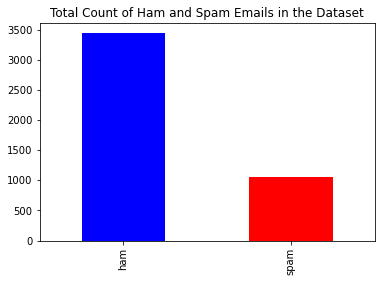

ham     3437
spam    1058
Name: label, dtype: int64


In [61]:
# Displaying the total count of ham and spam emails in the dataset
mailframe['label'].value_counts().plot.bar(color = ["b","r"])
plt.title('Total Count of Ham and Spam Emails in the Dataset')
plt.show()
print(mailframe['label'].value_counts())

# Preprocessing Mail Text 

In [62]:
stemmer = WordNetLemmatizer()

# Creating a function to process text in the email message
def process_mail(text):
    
    #1 remove punctuation
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)

    #2 remove stopwords
    stop_words = set(stopwords.words('english')) 
    clean_words = [word for word in no_punctuation.split() if word.lower() not in stop_words]
       
    # lemmatization
    clean_words = [stemmer.lemmatize(word) for word in clean_words]
    
    #3 return a list of clean text words
    return clean_words

In [63]:
# Show the tokenizations
mailframe['message'].head().apply(process_mail)

328     [UTF8BRnJhbmNlIFNlaXplcyBGcmFuY2UuY29tLiBCZXpv...
2769                        [Complete, application, None]
2811                            [never, many, deal, None]
2494    [Start, Building, Kingdom, Women, Life, Video,...
2163    [iso885915BRnJlZSBiYWNrLXRvLXNjaG9vbCB3ZWJpbmF...
Name: message, dtype: object

In [64]:
# Convert the collection of text to a matrix of token counts
cVect = CountVectorizer(analyzer = process_mail)
x = cVect.fit_transform((mailframe['message']))

y = mailframe.label

In [65]:
#Display number of tokens
print('Number of tokens: ', x.shape[1])

Number of tokens:  90725


# Splitting Data into Training and Testing Sets

In [66]:
# Split dataset into 80% training and 20% testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 0)


In [67]:
print(f"Shape of training data: {x_train.shape}\nShape of testing data: {x_test.shape}")

Shape of training data: (3596, 90725)
Shape of testing data: (899, 90725)


# Creating Models

In [68]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from time import perf_counter

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [69]:
models = {
    "Decision Tree": {"model":DecisionTreeClassifier(), "perf":0},
    "Naive Bayes": {"model":MultinomialNB(), "perf":0},
    "Random Forest": {"model":RandomForestClassifier(), "perf":0},
    "Logistic Regression": {"model":LogisticRegression(), "perf":0},
    "KNN": {"model":KNeighborsClassifier(), "perf":0},
    "SVM": {"model":SVC(), "perf":0},
    "SGD": {"model":SGDClassifier(), "perf":0},
    "GBM": {"model":GradientBoostingClassifier(), "perf":0},
    "XGBoost": {"model":XGBClassifier(eval_metric='mlogloss'), "perf":0},
}

for name, model in models.items():
    start = perf_counter()
    model["model"].fit(x_train, y_train)
    duration = perf_counter() - start
    duration = round(duration,2)
    model["perf"] = duration
    print(f"{name:20} trained in {duration} sec")

Decision Tree        trained in 1.28 sec
Naive Bayes          trained in 0.01 sec
Random Forest        trained in 14.74 sec


C:\Users\Maram\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression  trained in 1.38 sec
KNN                  trained in 0.01 sec
SVM                  trained in 4.09 sec
SGD                  trained in 0.04 sec
GBM                  trained in 42.64 sec


C:\Users\Maram\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBoost              trained in 4.98 sec


In [70]:
models_acc = []
for name, model in models.items():
    models_acc.append([name, model["model"].score(x_test, y_test), 
                       model["perf"]])

In [71]:
models_ass = []
for name, model in models.items():
    # Making predictions
    predicted_class = model["model"].predict(x_test)
    
    # Calculating the performance
    models_ass.append([name, 
                       accuracy_score(y_test, predicted_class), 
                       precision_score(y_test, predicted_class, pos_label = 'spam'),
                       recall_score(y_test, predicted_class, pos_label = 'spam'),
                       f1_score(y_test,predicted_class,pos_label = 'spam'),
                       roc_auc_score(np.where(y_test=='spam',1,0),np.where(predicted_class=='spam',1,0)),
                       model["perf"]])

In [72]:
df_ass = pd.DataFrame(models_ass)
df_ass.columns = ['Model', 'Accuracy', 'Recall', 'Precision', 'F1-Score', 'AUC', 'Training Time (sec)']
#df_ass.sort_values(by = 'Accuracy', ascending = False, inplace=True)
df_ass.reset_index(drop = True, inplace=True)
df_ass

,Model,Accuracy,Recall,Precision,F1-Score,AUC,Training Time (sec)
0,Decision Tree,0.928810,0.930481,0.773333,0.844660,0.877023,1.28
1,Naive Bayes,0.876529,0.771429,0.720000,0.744828,0.824392,0.01
2,Random Forest,0.892102,0.963768,0.591111,0.732782,0.791846,14.74
3,Logistic Regression,0.903226,0.910714,0.680000,0.778626,0.828872,1.38
4,KNN,0.848721,0.783439,0.546667,0.643979,0.748111,0.01
5,SVM,0.868743,1.000000,0.475556,0.644578,0.737778,4.09
6,SGD,0.917686,0.899471,0.755556,0.821256,0.863683,0.04
7,GBM,0.915462,0.980645,0.675556,0.800000,0.835552,42.64
8,XGBoost,0.921023,0.987342,0.693333,0.814621,0.845183,4.98


# Visualization

## Confusion Matrix 

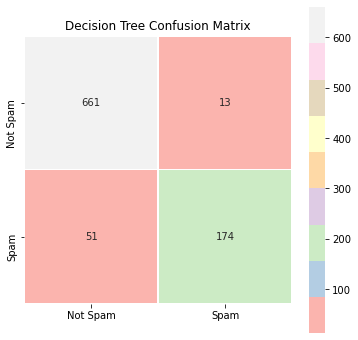

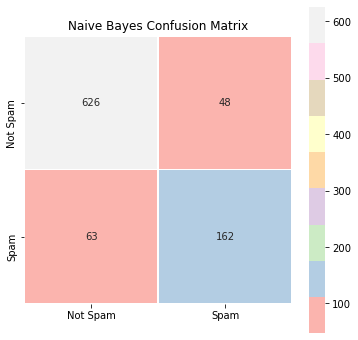

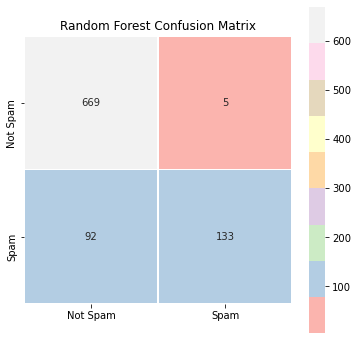

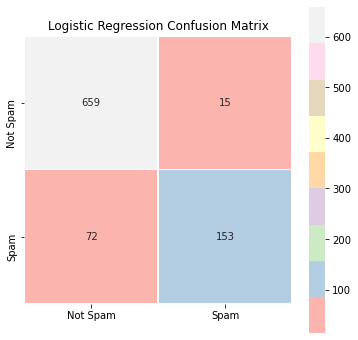

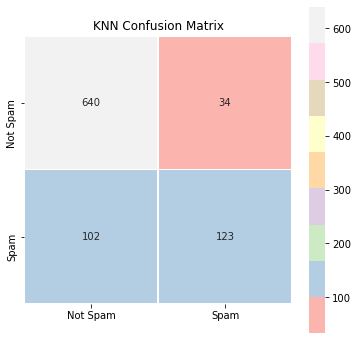

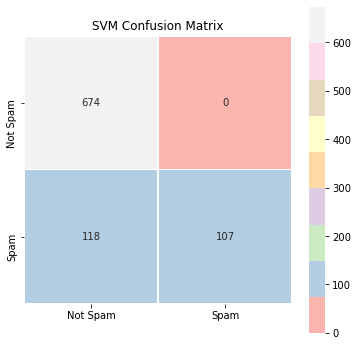

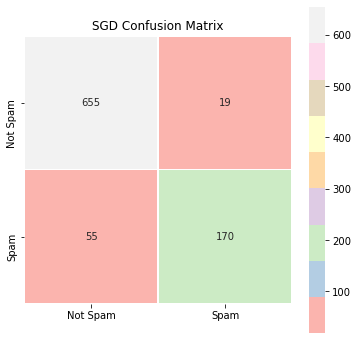

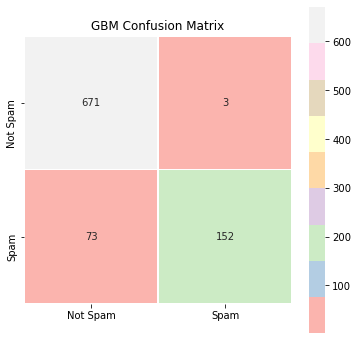

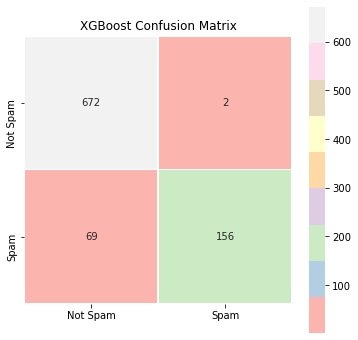

In [73]:
# Displaying confusion matrix for each model
for name, model in models.items():
    predicted_class = model["model"].predict(x_test)
    cmat = confusion_matrix(y_test, predicted_class)
    plt.figure(figsize = (6, 6))
    plt.title(name + ' Confusion Matrix')
    sns.heatmap(cmat, annot=True, fmt=".0f", linewidths=0.5, square = True, cmap = 'Pastel1',
                xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])

## Accuracy 

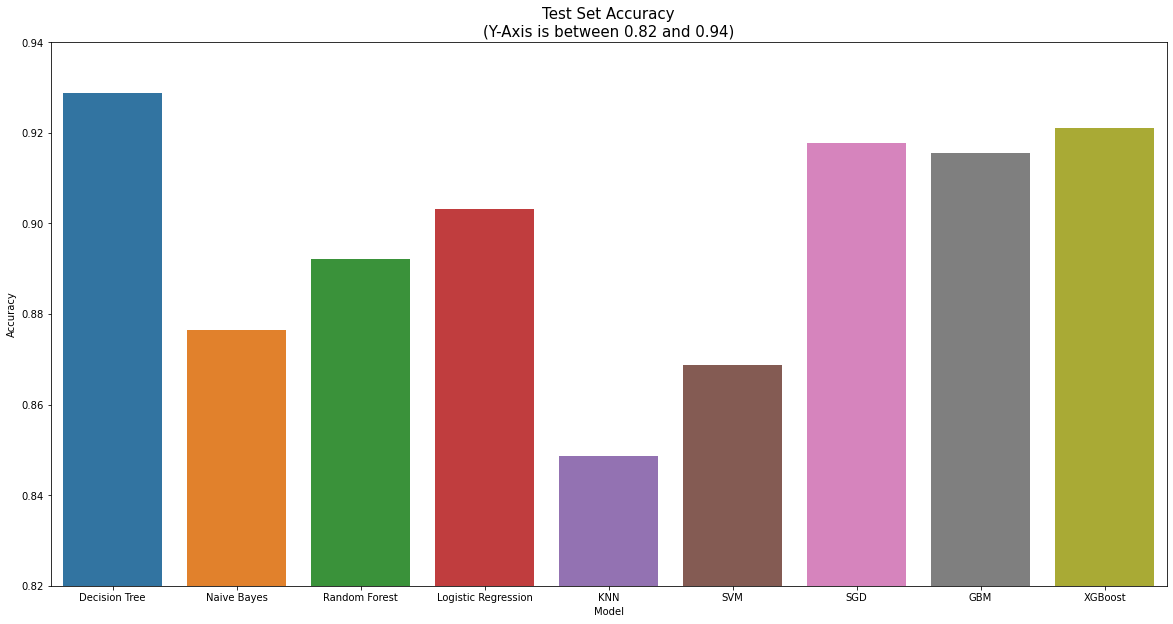

In [78]:
# Comparing the accuracy for each model
plt.figure(figsize = (20,10))
sns.barplot(x = 'Model', y = 'Accuracy', data = df_ass)
plt.title('Test Set Accuracy\n(Y-Axis is between 0.82 and 0.94)', fontsize = 15)
plt.ylim(0.82, 0.94)
plt.show()

## Training Time 

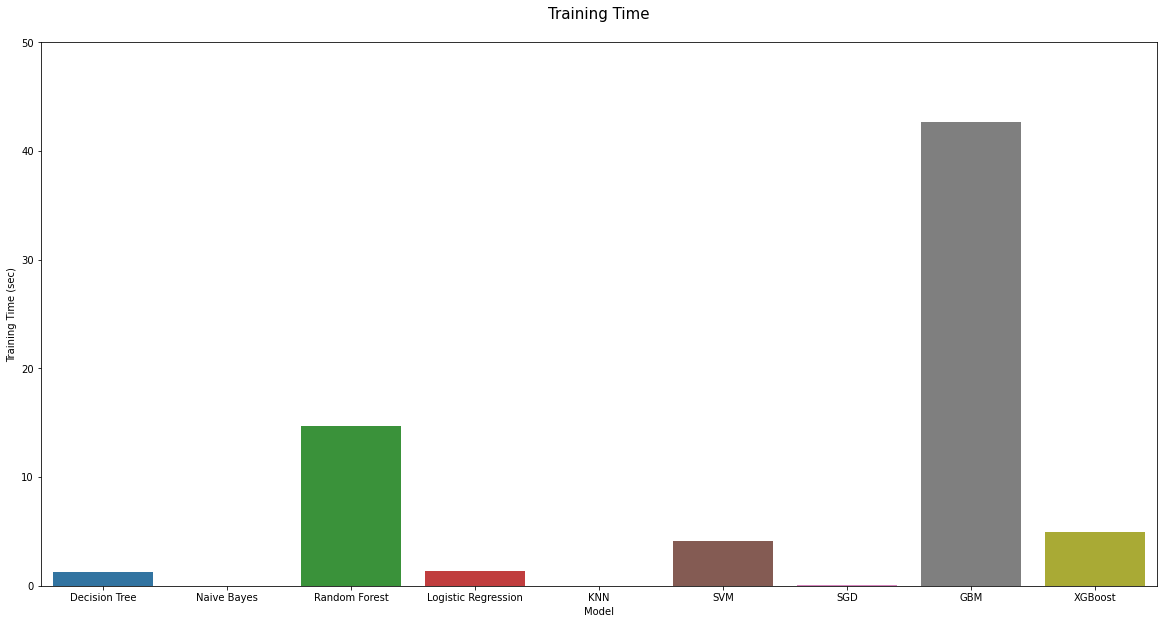

In [81]:
# Comparing the time for each model
plt.figure(figsize = (20, 10))
sns.barplot(x = 'Model', y = 'Training Time (sec)', data = df_ass)
plt.title('Training Time\n', fontsize = 15)
plt.ylim(0, 50)
plt.show()